#  1 Preparing data

installs

In [5]:
#%pip install catboost
#%pip install imbalanced_learn==0.11.0
#%pip install imblearn==0.0
#%pip install matplotlib==3.6.2
#%pip install numpy==1.23.5
#%pip install pandas==2.2.0
#%pip install scikit_learn==1.4.0
#%pip install seaborn==0.13.2

## 1.1 Reading Data

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from catboost import CatBoostClassifier
from catboost import Pool
filepath='./data/catB_train.parquet'
df = pd.read_parquet(filepath)

## 1.2 Data Visualisation

## 1.2 Processing Data

We fill in the target columns that are missing with 0. 1 indicates that the client bought an insurance policy within 3 months and 0 means that the client did not

In [7]:
df["f_purchase_lh"] = df["f_purchase_lh"].fillna(0)

Here we plot a graph to show the proportion of clients who bought and did not buy within 3 months and we can see that the number is very skewed

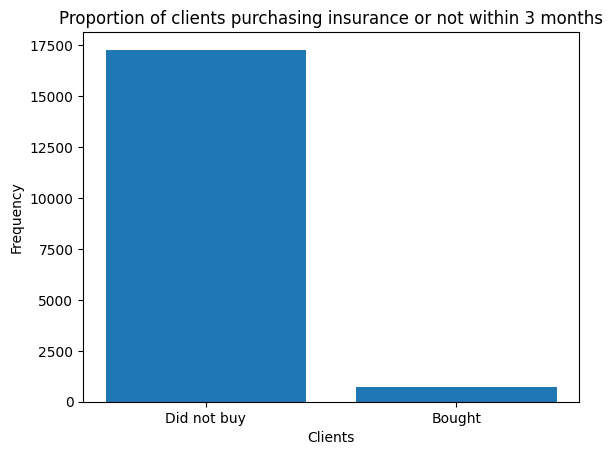

In [8]:
plt.bar([0,1], df['f_purchase_lh'].value_counts(), tick_label=['Did not buy','Bought'])
plt.title('Proportion of clients purchasing insurance or not within 3 months')
plt.xlabel('Clients')
plt.ylabel('Frequency')
plt.show()

In [9]:
df.replace('None',None,inplace=True)

In [10]:
df['min_occ_date'].isna().value_counts()

min_occ_date
False    17982
True        10
Name: count, dtype: int64

We removed the client id as it is irrelevant for predicting.

In [11]:
df=df.drop(columns=['clntnum'])

We then created a column which indicates the client's age when they bought the policy

In [12]:
df['adjusted_first_purchase'] = (datetime.datetime.now()-pd.to_datetime(df['min_occ_date']).fillna(pd.to_datetime(df['min_occ_date']).median())).dt.days/365
df['adjusted_dob'] = (datetime.datetime.now()-pd.to_datetime(df['cltdob_fix']).fillna(pd.to_datetime(df['cltdob_fix']).median())).dt.days/365
df=df.drop(columns=['cltdob_fix', 'min_occ_date'])

In [13]:
df['client_first_purchase_age']=df['adjusted_dob']-df['adjusted_first_purchase']

This is a histogram of the age for the clients

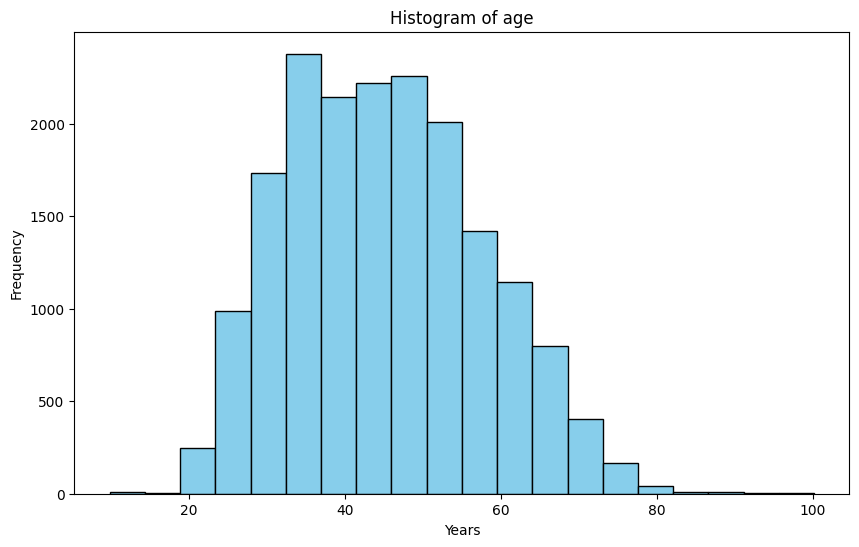

In [14]:
plt.figure(figsize=(10, 6))
plt.hist(df['adjusted_dob'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of age')
plt.xlabel('Years')
plt.ylabel('Frequency')
plt.show()

This graph shows the histogram of client's age when they first purchased the policy

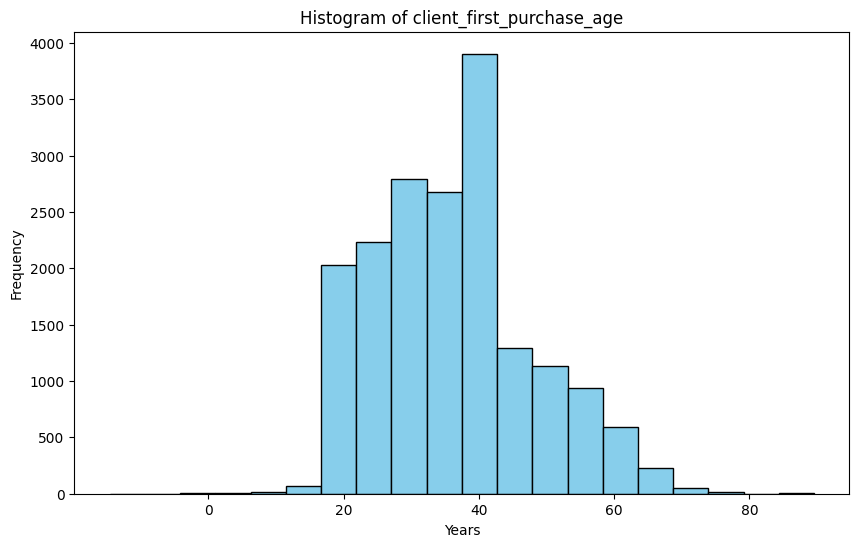

In [15]:
plt.figure(figsize=(10, 6))
plt.hist(df['client_first_purchase_age'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of client_first_purchase_age')
plt.xlabel('Years')
plt.ylabel('Frequency')
plt.show()

In [16]:
negative_values = df[df['client_first_purchase_age'] < 0]
negative_values

,race_desc,ctrycode_desc,clttype,stat_flag,cltsex_fix,flg_substandard,flg_is_borderline_standard,flg_is_revised_term,flg_is_rental_flat,flg_has_health_claim,...,giclaim_cnt_unsuccess,recency_giclaim_unsuccess,flg_gi_claim_29d435_ever,flg_gi_claim_058815_ever,flg_gi_claim_42e115_ever,flg_gi_claim_856320_ever,f_purchase_lh,adjusted_first_purchase,adjusted_dob,client_first_purchase_age
6542,None,Singapore,C,LAPSED,Female,1.0,0.0,0.0,0.0,0.0,...,None,None,None,None,None,None,0.0,29.372603,14.769863,-14.60274


We have a list of clients from different countries but we see that Singaporean and Malaysian clients are more likely to be in the client list

In [17]:
df['ctrycode_desc'].value_counts()

ctrycode_desc
Singapore               17789
Malaysia                   85
Not Applicable             20
Indonesia                  18
Australia                  10
United Kingdom              9
United States               5
China                       4
Thailand                    3
Taiwan (R.O.C)              3
Philippines                 3
Unknown Country Code        3
United Arab Emirates        3
Hong Kong                   2
Japan                       2
Denmark                     2
South Africa                2
Spain                       1
Brunei Darussalam           1
Sweden                      1
Ireland                     1
New Zealand                 1
Netherlands                 1
Italy                       1
Bosnia-Herzegovina          1
Canada                      1
Name: count, dtype: int64

We grouped the clients into Singaporeans, Malaysians and others and made them into categorical variables

In [18]:
df['ctrycode_grouped'] = df['ctrycode_desc'].apply(lambda x: x if x in ['Singapore', 'Malaysia'] else 'Others')
df=df.drop(columns=['ctrycode_desc'])

We see that Malaysians there are 85 Malaysians but none have bought an insurance within the last 3 months

In [19]:
print(df[df['ctrycode_grouped'] == 'Malaysia'].shape[0])
print(sum(df[df['ctrycode_grouped'] == 'Malaysia']['f_purchase_lh']))

85
0.0


Furthermore we see that there are 118 people who are not Singaporeans or Malaysians and none have bought an insurance within the last 3 months

In [20]:
print(df[df['ctrycode_grouped'].apply(lambda x:x not in ['Malaysia','Singapore'])].shape[0])
print(sum(df[df['ctrycode_grouped'].apply(lambda x:x  not in ['Malaysia','Singapore'])]['f_purchase_lh']))

118
0.0


Now we compare this with Singaporeans for which there are 17789 in the data and 710 of them bought an insurance within the last 3 months

In [21]:
print(df[df['ctrycode_grouped'] == 'Singapore'].shape[0])
print(sum(df[df['ctrycode_grouped'] == 'Singapore']['f_purchase_lh']))

17789
710.0


Below is the proportion of clients by nationality

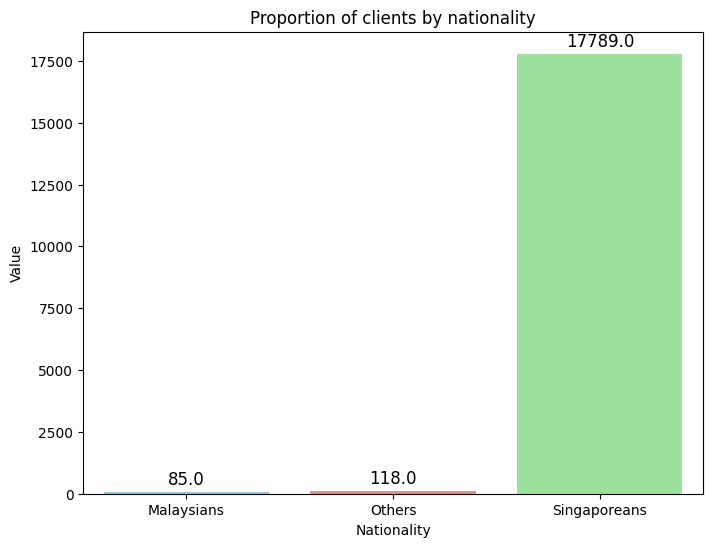

In [22]:
categories = ['Malaysians', 'Others', 'Singaporeans']
values_set1 = [df[df['ctrycode_grouped'] == 'Malaysia'].shape[0], df[df['ctrycode_grouped'].apply(lambda x:x not in ['Malaysia','Singapore'])].shape[0], 
               df[df['ctrycode_grouped'] == 'Singapore'].shape[0]] 

data = pd.DataFrame({'Nationality': categories, 'Value': values_set1})

colors = ['skyblue', 'salmon', 'lightgreen']

plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Nationality', y='Value', data=data, palette=colors)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()-50),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12)

plt.title('Proportion of clients by nationality')
plt.ylabel('Value')
plt.show()

Out of everyone in the client list, only Singaporeans bought insurance

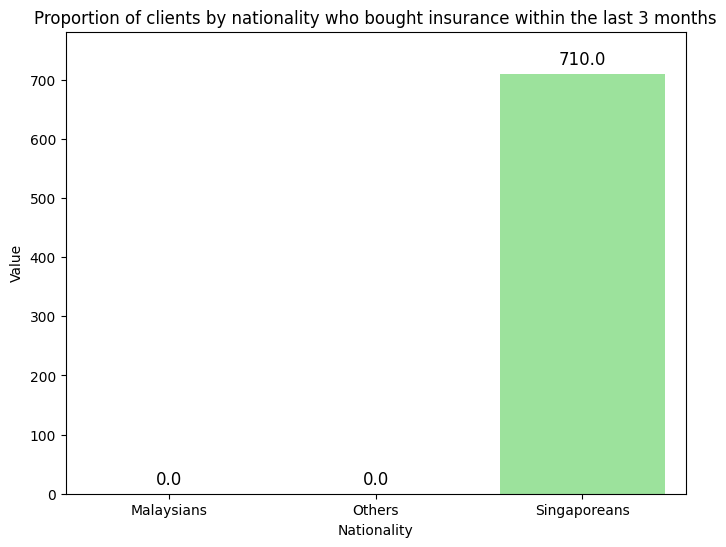

In [23]:
categories = ['Malaysians', 'Others', 'Singaporeans']
values_set1 = [sum(df[df['ctrycode_grouped'] == 'Malaysia']['f_purchase_lh']), sum(df[df['ctrycode_grouped'].apply(lambda x:x not in ['Malaysia','Singapore'])]['f_purchase_lh']), 
               sum(df[df['ctrycode_grouped'] == 'Singapore']['f_purchase_lh'])]

data = pd.DataFrame({'Nationality': categories, 'Value': values_set1})

colors = ['skyblue', 'salmon', 'lightgreen']

plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Nationality', y='Value', data=data, palette=colors)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12)
plt.ylim(0, max(data['Value']) * 1.1)
plt.title('Proportion of clients by nationality who bought insurance within the last 3 months')
plt.ylabel('Value')
plt.show()

For race, we filled the missing values with others

In [24]:
df['race_desc'] = df['race_desc'].fillna('Others')
df['race_desc'].value_counts()

race_desc
Chinese    10520
Others      5695
Malay        928
Indian       849
Name: count, dtype: int64

Since there are only 2 values for sex we filled the missing values with the most common gender which happens to be male.

In [25]:
df['cltsex_fix'] = df['cltsex_fix'].fillna(df['cltsex_fix'].mode()[0])
df['cltsex_fix'].value_counts()

cltsex_fix
Male      9796
Female    8196
Name: count, dtype: int64

We have the flag columns which are binary variables which indicates the various risk and status indicators

In [26]:
flag_columns = [
    'flg_substandard',
    'flg_is_borderline_standard',
    'flg_is_revised_term',
    'flg_is_rental_flat',
    'flg_has_health_claim',
    'flg_has_life_claim',
    'flg_gi_claim',
    'flg_is_proposal',
    'flg_with_preauthorisation',
    'flg_is_returned_mail'
]

We then sum up the risk indicators

In [27]:
df[flag_columns] = df[flag_columns].fillna(0)

In [28]:
df['flag_sum'] = df[flag_columns].sum(axis=1)

In [29]:
df=df.drop(columns=flag_columns)

Similarly we sum up the consent to getting contacted and valid contact points

In [30]:
consent_columns = [
    'is_consent_to_mail',
    'is_consent_to_email',
    'is_consent_to_call',
    'is_consent_to_sms'
]

validity_columns = [
    'is_valid_dm',
    'is_valid_email'
]

In [31]:
df[consent_columns] = df[consent_columns].fillna(0)
df[validity_columns] = df[validity_columns].fillna(0)

In [32]:
df['communication_consent_sum'] = df[consent_columns].sum(axis=1)
df['communication_validity_sum'] = df[validity_columns].sum(axis=1)

In [33]:
df=df.drop(columns=[*consent_columns,*validity_columns])

In [34]:
df['hh_size_est'] = df['hh_size_est'].replace('>4', '5')
df['hh_size_est'] = pd.to_numeric(df['hh_size_est'])

Then for the annual income of clients, we filled the missing values with 0 and Below 30K with 1 etc with the purpose of creating it into ordinal values. Which means that they have an order to it and 5 is the highest amount while 0 is the lowest.

In [35]:
df['annual_income_est'] = df['annual_income_est'].fillna(0)
income_ranges = {
    0:0,
    'E.BELOW30K': 1,
    'D.30K-60K': 2,
    'C.60K-100K': 3,
    'B.100K-200K': 4,
    'A.ABOVE200K': 5
}
df['annual_income_est'] = df['annual_income_est'].apply(lambda x: income_ranges[x])


We also have other categorical variables such as housewife retiree, is sg pr, is class 1 or 2 and dependent in at least another policy. We fill these missing values with the most common values found in the column

In [36]:
columns_to_fill_median = ['is_housewife_retiree', 'is_sg_pr', 'is_class_1_2', 'is_dependent_in_at_least_1_policy']

# Fill NaN values with the median in the specified columns (If there are more 1 than 0 then the value will become 1)
df[columns_to_fill_median] = df[columns_to_fill_median].fillna(df[columns_to_fill_median].median())

We then fill the 

In [37]:
df['hh_size'] .fillna(df['hh_size'].mean())

19550    1.402778
4600     3.137255
13337    2.887097
15074    4.000000
19724    4.192982
           ...   
11284    3.211765
11964    0.000000
5390     3.372093
860      4.486111
15795    3.235775
Name: hh_size, Length: 17992, dtype: float64

Here we have hh_20 and pop_20, we keep both and removed hh_size and hh_size_est as the 2 latter can be calculated from the first two columns

In [38]:
columns_to_fill_median = ['hh_20', 'pop_20']
column_to_remove = ['hh_size_est', 'hh_size']
df[columns_to_fill_median] = df[columns_to_fill_median].apply(pd.to_numeric, errors='coerce')
df[columns_to_fill_median] = df[columns_to_fill_median].fillna(df[columns_to_fill_median].median(skipna=True))
df=df.drop(columns=column_to_remove)


In [39]:
filtered_columns = df.filter(like='ape_').columns.tolist() + \
                    df.filter(like='sumins_').columns.tolist() + \
                    df.filter(like='prempaid_').columns.tolist()

df[filtered_columns] = df[filtered_columns].fillna(0)

We sum up the annual premium equivalent, sum insured and premium paid together

In [40]:
prefixes=['ape','sumins','prempaid']
for prefix in prefixes:
    columns_to_sum = df.filter(like=f'{prefix}').columns
    df[f'sum_{prefix}'] = df[columns_to_sum].astype(float).sum(axis=1)

C:\Users\User\AppData\Local\Temp\ipykernel_23968\1256613071.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'sum_{prefix}'] = df[columns_to_sum].astype(float).sum(axis=1)
C:\Users\User\AppData\Local\Temp\ipykernel_23968\1256613071.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'sum_{prefix}'] = df[columns_to_sum].astype(float).sum(axis=1)
C:\Users\User\AppData\Local\Temp\ipykernel_23968\1256613071.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

In [41]:
df=df.drop(columns=filtered_columns)

In [42]:
metric_columns = [
    'n_months_last_bought_products',
    'flg_latest_being_lapse',
    'flg_latest_being_cancel',
    'recency_lapse',
    'recency_cancel',
    'tot_inforce_pols',
    'tot_cancel_pols',
    'f_ever_declined_la'
]

In [43]:
for col in metric_columns:
    print(f"NaN counts for {col}: {df[col].isna().sum()}")

NaN counts for n_months_last_bought_products: 0
NaN counts for flg_latest_being_lapse: 0
NaN counts for flg_latest_being_cancel: 0
NaN counts for recency_lapse: 12592
NaN counts for recency_cancel: 17368
NaN counts for tot_inforce_pols: 0
NaN counts for tot_cancel_pols: 17368
NaN counts for f_ever_declined_la: 16759


We remove number of months last bought (product code) as there were too many features to keep and n_months_last_bought_products is concise enough to tell us how many months ago did the client purchase an insurance

In [44]:
filtered_columns_last_bought = df.filter(like = 'n_months_last_bought').drop(columns = 'n_months_last_bought_products').columns.tolist()
filtered_columns_last_bought

['n_months_last_bought_839f8a',
 'n_months_last_bought_e22a6a',
 'n_months_last_bought_d0adeb',
 'n_months_last_bought_c4bda5',
 'n_months_last_bought_ltc',
 'n_months_last_bought_507c37',
 'n_months_last_bought_gi',
 'n_months_last_bought_ltc_1280bf',
 'n_months_last_bought_grp_6fc3e6',
 'n_months_last_bought_grp_de05ae',
 'n_months_last_bought_inv_dcd836',
 'n_months_last_bought_grp_945b5a',
 'n_months_last_bought_grp_6a5788',
 'n_months_last_bought_ltc_43b9d5',
 'n_months_last_bought_grp_9cdedf',
 'n_months_last_bought_lh_d0adeb',
 'n_months_last_bought_grp_1581d7',
 'n_months_last_bought_grp_22decf',
 'n_months_last_bought_lh_507c37',
 'n_months_last_bought_lh_839f8a',
 'n_months_last_bought_inv_e9f316',
 'n_months_last_bought_grp_caa6ff',
 'n_months_last_bought_grp_fd3bfb',
 'n_months_last_bought_lh_e22a6a',
 'n_months_last_bought_grp_70e1dd',
 'n_months_last_bought_grp_e04c3a',
 'n_months_last_bought_grp_fe5fb8',
 'n_months_last_bought_grp_94baec',
 'n_months_last_bought_grp_e914

In [45]:
df = df.drop(columns=filtered_columns_last_bought)

We filled the missing values in affconnect with 0

In [46]:
flags=['flg_affconnect_show_interest_ever', 'flg_affconnect_ready_to_buy_ever',
       'flg_affconnect_lapse_ever']
for f in flags:
    print(df[f].value_counts())

flg_affconnect_show_interest_ever
1.0    495
Name: count, dtype: int64
flg_affconnect_ready_to_buy_ever
1.0    814
Name: count, dtype: int64
flg_affconnect_lapse_ever
0.0    805
1.0      9
Name: count, dtype: int64


In [47]:
df[flags]=df[flags].fillna(0)

We sum up the gi_claim_ever but since there were no claims for any clients we subsequently removed it

In [48]:
columns_to_sum = ['flg_gi_claim_29d435_ever', 'flg_gi_claim_058815_ever', 'flg_gi_claim_42e115_ever', 'flg_gi_claim_856320_ever']
df['sum_gi_claim'] = df[columns_to_sum].sum(axis=1, skipna=True)
df['sum_gi_claim'] = df['sum_gi_claim'].fillna(0)

df=df.drop(columns=columns_to_sum)

In [49]:
df=df.drop(columns=['sum_gi_claim'])

We turn affcon_visit_days into a boolean of whether a person visited.

In [50]:
df['affcon_visited'] = df['affcon_visit_days'].fillna(0).apply(lambda x: int(x))
df=df.drop(columns='affcon_visit_days')

In [51]:
cancel_cols=['f_ever_declined_la','tot_cancel_pols','recency_cancel','recency_lapse']
df[cancel_cols]=df[cancel_cols].fillna(0)

We sum up ever bought.

In [52]:
filter_f_ever_bought = df.filter(like='f_ever_bought').columns.to_list()
df['sum_f_ever_bought']=df[filter_f_ever_bought].sum(axis=1)


In [53]:

df=df.drop(columns=filter_f_ever_bought)

We now sum up the success claims and the unsuccessful claims



In [54]:
claim_cnt_success = ['giclaim_cnt_success','hlthclaim_cnt_success']
df['claim_cnt_success'] = df[claim_cnt_success].fillna(0).sum(axis=1, skipna=True)
df=df.drop(columns=claim_cnt_success)
claim_cnt_unsuccess = ['hlthclaim_cnt_unsuccess', 'giclaim_cnt_unsuccess']
df['claim_cnt_unsuccess'] = df[claim_cnt_unsuccess].fillna(0).sum(axis=1, skipna=True)
df=df.drop(columns=claim_cnt_unsuccess)

For the remaining columns, we drop it to minimize the features added to the model to reduce the overfitting.

In [55]:
columns_n_months_since_lapse = df.filter(like='n_months_since_lapse').columns.to_list()
df=df.drop(columns=columns_n_months_since_lapse)

In [56]:
na_columns = df.columns[df.isna().any()]

print(na_columns)

Index(['n_months_since_visit_affcon', 'clmcon_visit_days', 'recency_clmcon',
       'recency_clmcon_regis', 'hlthclaim_amt', 'recency_hlthclaim',
       'recency_hlthclaim_success', 'recency_hlthclaim_unsuccess',
       'flg_hlthclaim_839f8a_ever', 'recency_hlthclaim_839f8a',
       'flg_hlthclaim_14cb37_ever', 'recency_hlthclaim_14cb37', 'giclaim_amt',
       'recency_giclaim', 'recency_giclaim_success',
       'recency_giclaim_unsuccess'],
      dtype='object')


In [57]:
df=df.drop(columns=na_columns)

## Clustering and data visualisation

In [58]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

We performed a Principal component analysis and showed the clusterings in 3D to see if there are clear outliers or if the clusters are close together

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Explained Variance Ratio for PC1: 12.62%
Explained Variance Ratio for PC2: 9.54%
Explained Variance Ratio for PC3: 6.04%


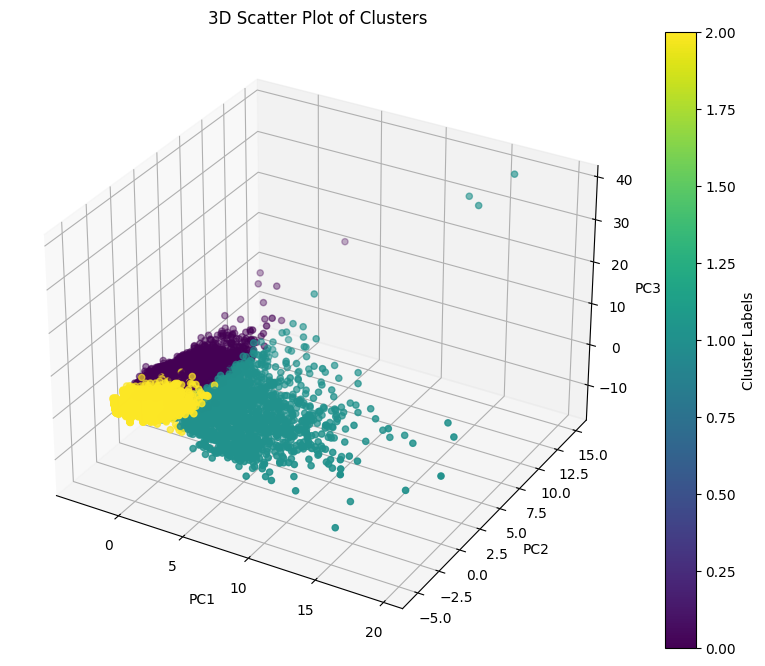

In [59]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df.drop(columns=df.select_dtypes(include=['string','object'])))
num_clusters = 3


kmeans = KMeans(n_clusters=num_clusters)


kmeans.fit(scaled_features)


cluster_labels = kmeans.labels_

pca = PCA(n_components=3)
reduced_features = pca.fit_transform(scaled_features)

explained_variance_ratio = pca.explained_variance_ratio_

for i in range(3):
    print(f"Explained Variance Ratio for PC{i+1}: {explained_variance_ratio[i]*100:.2f}%")
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2], c=cluster_labels, cmap='viridis')

# Adding colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster Labels')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.title('3D Scatter Plot of Clusters')

plt.show()

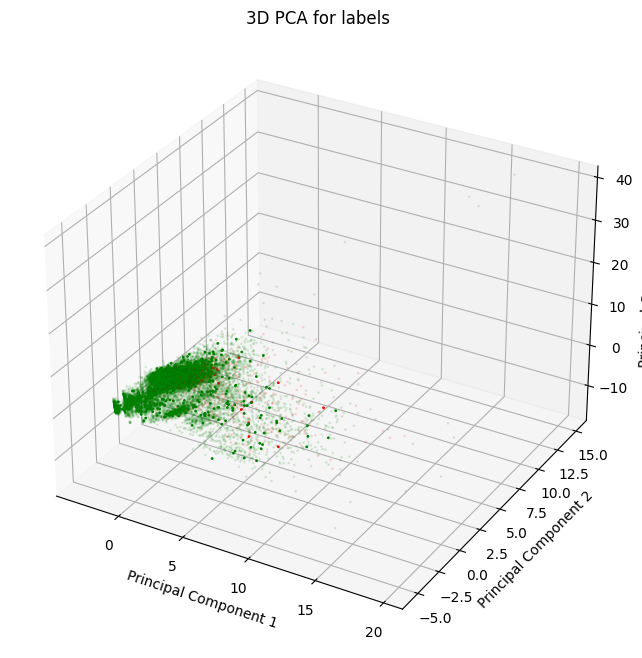

In [60]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
colors = np.where(df["f_purchase_lh"] == 1, 'red', 'green')

alpha = np.where(df["f_purchase_lh"] == 1, 1.0, 0.1)

ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2], c=colors, alpha=alpha, s=1)

ax.set_title('3D PCA for labels')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

plt.show()


In [61]:
X=df.drop(columns=["f_purchase_lh"])
y=df["f_purchase_lh"]

In [62]:
bool_columns = X.columns[(X.eq(0) | X.eq(1)).all()]
X[bool_columns] = X[bool_columns].astype(bool)
categorical_features=X.select_dtypes(include=['object','string']).columns.tolist()
categorical_features

['race_desc', 'clttype', 'stat_flag', 'cltsex_fix', 'ctrycode_grouped']

In [63]:
cat_feat=[*categorical_features,*bool_columns]

In [64]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import precision_recall_curve ,auc,roc_auc_score

We used Synthetic Minority Oversampling Technique (smote) to create synthethic data to form a more balanced dataset and in particular we used smoteNC instead of smote for categoical features as interpolating binary variables does not work.

## Precision-Recall Threshold
First, we have to find a lambda to act as the threshold.
Given that the challenge is to dissect the dataset to uncover the critical touchpoints that contribute to customer drop-off, we want to reduce the number of false positives (i.e Number of customers who do not buy but we predict that they buy) to reduce customer churn while also balancing false negatives (i.e Number of customers who buy but we predict that they do not buy) to reduce inefficient marketing.
Thus we use f1 score to devise a harmonic mean of precision and recall.

In [65]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, y_train = SMOTENC(categorical_features=cat_feat).fit_resample(X_train, y_train)
train_pool = Pool(X_train, label=y_train,cat_features=cat_feat)
test_pool = Pool(X_val, label=y_val,cat_features=cat_feat)

model = CatBoostClassifier(iterations=500, depth=8, learning_rate=0.1, loss_function='Logloss', verbose=False,cat_features=cat_feat)

model.fit(train_pool, eval_set=test_pool)


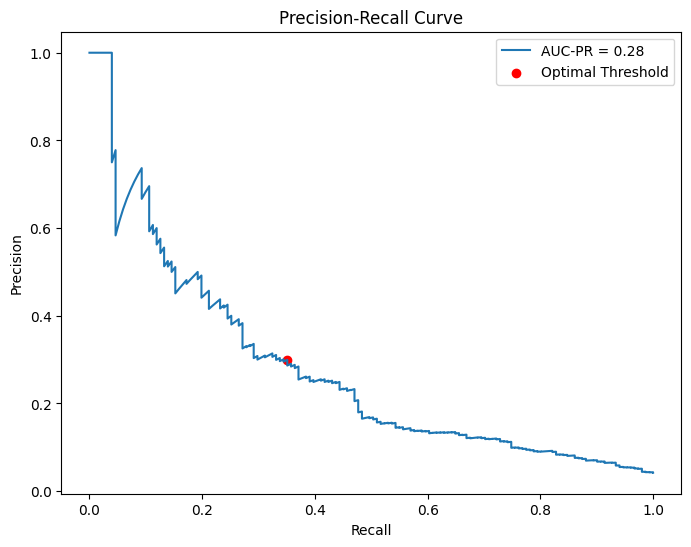

Optimal Threshold: 0.275210641914618


In [66]:
y_val_proba = model.predict_proba(X_val)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)

auc_pr = auc(recall, precision)
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_threshold_index = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_threshold_index]

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AUC-PR = {auc_pr:.2f}')
plt.scatter(recall[optimal_threshold_index], precision[optimal_threshold_index], marker='o', color='r', label='Optimal Threshold')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()
y_val_proba = model.predict_proba(X_val)[:, 1]

roc_auc = roc_auc_score(y_val, y_val_proba)
print(f'Optimal Threshold: {optimal_threshold}')

We used StratifiedKFold for imbalanced datasets because it maintains the original class distribution in each cross-validation fold. This ensures a more accurate representation during model evaluation, enhancing the reliability of the results. It helps the model generalize better across different class imbalances in the dataset.

In [67]:
# Number of folds
n_splits = 5
# Initialise Stratified KFold
stratified_kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
models_dict = {}

In [69]:
for fold,(train_index, test_index) in enumerate(stratified_kf.split(X, y)):
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    X_train, y_train = SMOTENC(categorical_features=cat_feat).fit_resample(X_train, y_train)
    train_pool = Pool(X_train, label=y_train,cat_features=cat_feat)
    test_pool = Pool(X_val, label=y_val,cat_features=cat_feat)

    model = CatBoostClassifier(iterations=500, depth=8, learning_rate=0.1, loss_function='Logloss', verbose=False,cat_features=cat_feat)
    model.fit(train_pool, eval_set=test_pool)
    models_dict[f"Fold_{fold+1}"] = model

In [70]:
def predict(models, X_input, cat_feat,thres=0.5):
    input_pool = Pool(X_input, cat_features=cat_feat)
    predictions = [ model.predict(input_pool) for model in models.values()]
    average_prediction = sum(predictions) / len(predictions)

    return average_prediction >= thres

In [71]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    df=hidden_data
    df.replace('None',None,inplace=True)
    df['adjusted_first_purchase'] = (datetime.datetime.now()-pd.to_datetime(df['min_occ_date']).fillna(pd.to_datetime(df['min_occ_date']).median())).dt.days/365
    df['adjusted_dob'] = (datetime.datetime.now()-pd.to_datetime(df['cltdob_fix']).fillna(pd.to_datetime(df['cltdob_fix']).median())).dt.days/365
    df['client_first_purchase_age']=df['adjusted_dob']-df['adjusted_first_purchase']
    df['ctrycode_desc']=df['ctrycode_desc'].fillna('Singapore')
    df['race_desc'] = df['race_desc'].fillna('Others')
    
    keys_to_drop = ['clntnum', 'min_occ_date', 'cltdob_fix']
    df = df.drop(columns=keys_to_drop)
    
    flag_columns = [
        'flg_substandard',
        'flg_is_borderline_standard',
        'flg_is_revised_term',
        'flg_is_rental_flat',
        'flg_has_health_claim',
        'flg_has_life_claim',
        'flg_gi_claim',
        'flg_is_proposal',
        'flg_with_preauthorisation',
        'flg_is_returned_mail'
    ]
    
    df[flag_columns] = df[flag_columns].fillna(0)
    df['flag_sum'] = df[flag_columns].sum(axis=1)
    df=df.drop(columns=flag_columns)
    df['cltsex_fix'] = df['cltsex_fix'].fillna(df['cltsex_fix'].mode()[0])
    consent_columns = [
    'is_consent_to_mail',
    'is_consent_to_email',
    'is_consent_to_call',
    'is_consent_to_sms'
    ]

    validity_columns = [
        'is_valid_dm',
        'is_valid_email'
    ]
    
    df[consent_columns] = df[consent_columns].fillna(0)
    df[validity_columns] = df[validity_columns].fillna(0)
    df['communication_consent_sum'] = df[consent_columns].sum(axis=1)
    df['communication_validity_sum'] = df[validity_columns].sum(axis=1)
    df=df.drop(columns=[*consent_columns,*validity_columns])
    claim_cnt_success = ['giclaim_cnt_success','hlthclaim_cnt_success']
    df['claim_cnt_success'] = df[claim_cnt_success].fillna(0).sum(axis=1, skipna=True)
    df=df.drop(columns=claim_cnt_success)
    claim_cnt_unsuccess = ['hlthclaim_cnt_unsuccess', 'giclaim_cnt_unsuccess']
    df['claim_cnt_unsuccess'] = df[claim_cnt_unsuccess].fillna(0).sum(axis=1, skipna=True)
    df=df.drop(columns=claim_cnt_unsuccess)
    col_to_drop = ['flg_gi_claim_29d435_ever', 'flg_gi_claim_058815_ever', 'flg_gi_claim_42e115_ever', 'flg_gi_claim_856320_ever']
    df=df.drop(columns=col_to_drop)
    
    
    columns_n_months_since_lapse = df.filter(like='n_months_since_lapse').columns.to_list()
    df=df.drop(columns=columns_n_months_since_lapse)
    
    size_drop = ['hh_size_est', 'hh_size']
    
    df=df.drop(columns=size_drop)

    df['annual_income_est'] = df['annual_income_est'].fillna(0)
    
    income_ranges = {
        0:0,
        'E.BELOW30K': 1,
        'D.30K-60K': 2,
        'C.60K-100K': 3,
        'B.100K-200K': 4,
        'A.ABOVE200K': 5
    }
    
    df['annual_income_est'] = df['annual_income_est'].apply(lambda x: income_ranges[x])
    columns_to_fill_median = ['is_housewife_retiree', 'is_sg_pr', 'is_class_1_2', 'is_dependent_in_at_least_1_policy','hh_20', 'pop_20']
    df[columns_to_fill_median] = df[columns_to_fill_median].apply(pd.to_numeric, errors='coerce')
    df[columns_to_fill_median] = df[columns_to_fill_median].fillna(df[columns_to_fill_median].median())
    df[columns_to_fill_median] = df[columns_to_fill_median].fillna(df[columns_to_fill_median].median(skipna=True))
    filtered_columns = df.filter(like='ape_').columns.tolist() + \
                    df.filter(like='sumins_').columns.tolist() + \
                    df.filter(like='prempaid_').columns.tolist()
    df[filtered_columns] = df[filtered_columns].fillna(0)
    prefixes=['ape','sumins','prempaid']
    for prefix in prefixes:
        columns_to_sum = df.filter(like=f'{prefix}').columns
        df[f'sum_{prefix}'] = df[columns_to_sum].astype(float).sum(axis=1)
    df=df.drop(columns=filtered_columns)
    flags=['flg_affconnect_show_interest_ever', 'flg_affconnect_ready_to_buy_ever',
       'flg_affconnect_lapse_ever']
    df[flags]=df[flags].fillna(0)

    df['affcon_visited'] = df['affcon_visit_days'].fillna(0).apply(lambda x: int(x))
    df=df.drop(columns='affcon_visit_days')
    cancel_cols=['f_ever_declined_la','tot_cancel_pols','recency_cancel','recency_lapse']
    df[cancel_cols]=df[cancel_cols].fillna(0)
    df['ctrycode_grouped'] = df['ctrycode_desc'].apply(lambda x: x if x in ['Singapore', 'Malaysia'] else 'Others')
    na_columns = df.columns[df.isna().any()]
    df=df.drop(columns=na_columns)
    
    filter_f_ever_bought = df.filter(like='f_ever_bought').columns.to_list()
    df['sum_f_ever_bought']=df[filter_f_ever_bought].sum(axis=1)
    df=df.drop(columns=filter_f_ever_bought)
    
    bool_columns = df.columns[(df.eq(0) | df.eq(1)).all()]
    df[bool_columns] = df[bool_columns].astype(bool)
    categorical_features=df.select_dtypes(include=['object','string']).columns.tolist()
    cat_feat=[*categorical_features,*bool_columns]
    result = predict(models_dict,df,cat_feat,optimal_threshold)
    return result

In [72]:
test_df = pd.read_parquet(filepath)
try:
    test_df = test_df.drop(columns=["f_purchase_lh"])
except Exception as e:
    print(e)
print(testing_hidden_data(test_df))

C:\Users\User\AppData\Local\Temp\ipykernel_23968\1054342421.py:87: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'sum_{prefix}'] = df[columns_to_sum].astype(float).sum(axis=1)
C:\Users\User\AppData\Local\Temp\ipykernel_23968\1054342421.py:87: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'sum_{prefix}'] = df[columns_to_sum].astype(float).sum(axis=1)
C:\Users\User\AppData\Local\Temp\ipykernel_23968\1054342421.py:87: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` m

[False False False ... False False False]
